In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [43]:
train_df = pd.read_csv("C://Users//altho//DNA_PREDICTION//data//train.csv")
val_df = pd.read_csv("C://Users//altho//DNA_PREDICTION//data//validation.csv")
test_df = pd.read_csv("C://Users//altho//DNA_PREDICTION//data//test.csv")

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)


Train shape: (22593, 7)
Validation shape: (4577, 7)
Test shape: (8326, 7)


In [44]:
print(train_df.head())
print(train_df.info())
print(train_df.describe())
print(train_df.isnull().sum())
print(train_df.dtypes)

   Unnamed: 0  ...                                 NucleotideSequence
0           0  ...  <AGCTTAGCACAGTGGCAGTATCATAGGCAGTGAGGTTTATCCGAG...
1           1  ...  <CTGGAGCGGCCACGATGTGAACTGTCACCGGCCACTGCTGCTCCG...
2           2  ...  <TTCCCAATTTTTCCTCTGCTTTTTAATTTTCTAGTTTCCTTTTTC...
3           3  ...  <CGCCCAGGCTGGAGTGCAGTGGCGCCATCTCGGCTCACTGCAGGC...
4           4  ...                     <AGCATATTGTGGTGGTGACTGCTATTCC>

[5 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22593 entries, 0 to 22592
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          22593 non-null  int64 
 1   NCBIGeneID          22593 non-null  int64 
 2   Symbol              22593 non-null  object
 3   Description         22593 non-null  object
 4   GeneType            22593 non-null  object
 5   GeneGroupMethod     22593 non-null  object
 6   NucleotideSequence  22593 non-null  object
dtypes: int64(2), 

count    22593.000000
mean       361.724871
std        260.474730
min          4.000000
25%        122.000000
50%        297.000000
75%        520.000000
max       1002.000000
Name: SeqLength, dtype: float64


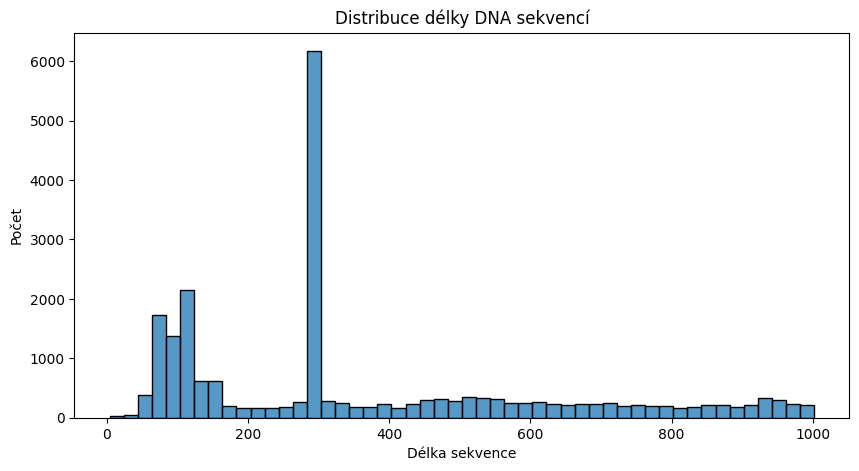

Frekvence nukleotidů: Counter({'A': 2153207, 'T': 2061171, 'G': 1971942, 'C': 1940944})


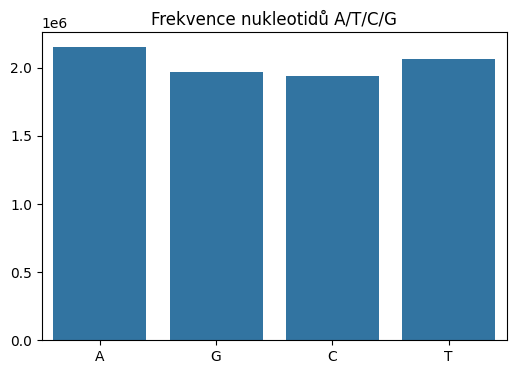

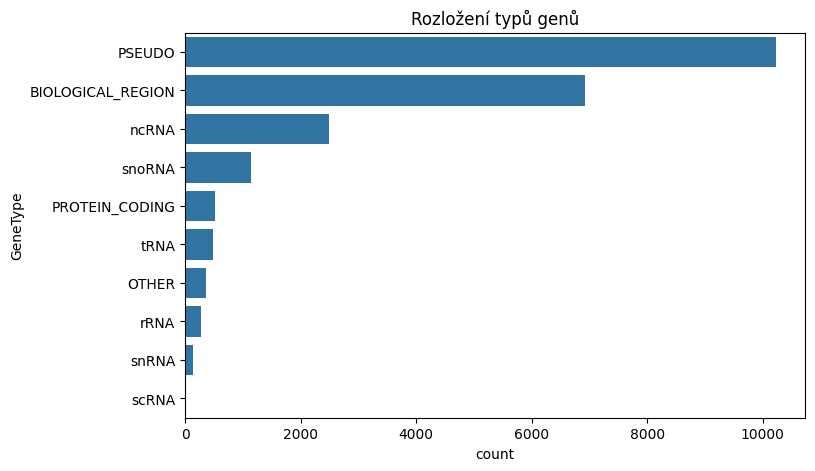

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Délky sekvencí
train_df['SeqLength'] = train_df['NucleotideSequence'].str.len()
print(train_df['SeqLength'].describe())

plt.figure(figsize=(10,5))
sns.histplot(train_df['SeqLength'], bins=50)
plt.title("Distribuce délky DNA sekvencí")
plt.xlabel("Délka sekvence")
plt.ylabel("Počet")
plt.show()

# 2. Frekvence nukleotidů
from collections import Counter

all_seq = "".join(train_df['NucleotideSequence'].str.replace("<","").str.replace(">",""))
nuc_count = Counter(all_seq)
print("Frekvence nukleotidů:", nuc_count)

plt.figure(figsize=(6,4))
sns.barplot(x=list(nuc_count.keys()), y=list(nuc_count.values()))
plt.title("Frekvence nukleotidů A/T/C/G")
plt.show()

# 3. Distribuce typů genů
plt.figure(figsize=(8,5))
sns.countplot(y='GeneType', data=train_df, order=train_df['GeneType'].value_counts().index)
plt.title("Rozložení typů genů")
plt.show()



In [46]:
nucleotide_to_idx = {'A':0, 'C':1, 'G':2, 'T':3}

train_df['NucleotideSequence'] = train_df['NucleotideSequence'].str.replace("<|>", "", regex=True)
train_df['SeqIndexed'] = train_df['NucleotideSequence'].apply(lambda seq: [nucleotide_to_idx[n] for n in seq])


val_df['NucleotideSequence'] = val_df['NucleotideSequence'].str.replace("<|>", "", regex=True)
val_df['SeqIndexed'] = val_df['NucleotideSequence'].apply(lambda seq: [nucleotide_to_idx[n] for n in seq])

test_df['NucleotideSequence'] = test_df['NucleotideSequence'].str.replace("<|>", "", regex=True)
test_df['SeqIndexed'] = test_df['NucleotideSequence'].apply(lambda seq: [nucleotide_to_idx[n] for n in seq])

In [47]:
from collections import defaultdict, Counter

def build_bigram_model(sequences):
    model = defaultdict(Counter)
    for seq in sequences:
        for i in range(len(seq)-1):
            model[seq[i]][seq[i+1]] += 1
    # Převedeme na pravděpodobnosti
    for current_nuc, counter in model.items():
        total = sum(counter.values())
        for next_nuc in counter:
            counter[next_nuc] /= total
    return model

bigram_model = build_bigram_model(train_df['NucleotideSequence'])
print("Bigram model:", bigram_model)


Bigram model: defaultdict(<class 'collections.Counter'>, {'A': Counter({'A': 0.29597030570046473, 'G': 0.28524461956276037, 'T': 0.22331313848779616, 'C': 0.1954719362489787}), 'G': Counter({'G': 0.27717437161664166, 'A': 0.27059038808549574, 'C': 0.24273057666404046, 'T': 0.20950466363382214}), 'C': Counter({'A': 0.3219817789998998, 'T': 0.3114272084159832, 'C': 0.28416747294368383, 'G': 0.08242353964043315}), 'T': Counter({'G': 0.31530125489211314, 'T': 0.27363276326406266, 'C': 0.2381263145805168, 'A': 0.17293966726330737})})


In [48]:
import random

def predict_next_nucleotide(current_nuc, model):
    if current_nuc not in model:
        return random.choice(['A', 'C', 'G', 'T'])  # fallback
    probs = model[current_nuc]
    nucleotides = list(probs.keys())
    probabilities = list(probs.values())
    return random.choices(nucleotides, weights=probabilities, k=1)[0]


In [49]:
test_seq = train_df['NucleotideSequence'].iloc[0]
next_nuc = predict_next_nucleotide(test_seq[0], bigram_model)
print(f"Aktuální nukleotid: {test_seq[0]}, Predikovaný další: {next_nuc}")


Aktuální nukleotid: A, Predikovaný další: C


In [50]:
def predict_next_bigram(seq, bigram_counts):
    prediction = ""
    for i in range(len(seq)-1):
        current = seq[i]
        if current in bigram_counts:
            # predikce podle nejčastějšího následujícího nukleotidu
            next_nuc = max(bigram_counts[current], key=bigram_counts[current].get)
        else:
            next_nuc = "A"  # fallback
        prediction += next_nuc
    return prediction

In [51]:
correct = 0
total = 0
for seq in val_df['NucleotideSequence']:
    pred_seq = predict_next_bigram(seq, bigram_model)
    for i in range(1, len(seq)):
        total += 1
        if pred_seq[i-1] == seq[i]:
            correct += 1

accuracy = correct / total
print(f"Accuracy on validation set: {accuracy:.4f}")

Accuracy on validation set: 0.3039


In [52]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


In [53]:
train_df['NucleotideSequence'] = train_df['NucleotideSequence'].str.replace("<|>", "", regex=True)
val_df['NucleotideSequence'] = val_df['NucleotideSequence'].str.replace("<|>", "", regex=True)


nucleotide_to_idx = {'A':0, 'C':1, 'G':2, 'T':3}
idx_to_nucleotide = {v:k for k,v in nucleotide_to_idx.items()}


train_df['SeqIndexed'] = train_df['NucleotideSequence'].apply(lambda seq: [nucleotide_to_idx[n] for n in seq if n in nucleotide_to_idx])
val_df['SeqIndexed'] = val_df['NucleotideSequence'].apply(lambda seq: [nucleotide_to_idx[n] for n in seq if n in nucleotide_to_idx])


In [54]:
def create_dataset(sequences, seq_length=50):
    X, y = [], []
    for seq in sequences:
        if len(seq) <= seq_length:  # moc krátké přeskočíme
            continue
        for i in range(len(seq) - seq_length):
            X.append(seq[i:i+seq_length])    # vstupní okno
            y.append(seq[i+seq_length])      # následující znak
    return np.array(X), np.array(y)

seq_length = 100
X_train, y_train = create_dataset(train_df['SeqIndexed'], seq_length)
X_val, y_val = create_dataset(val_df['SeqIndexed'], seq_length)

# krok 5: one-hot encoding pro y
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

# krok 6: reshape vstupů pro LSTM [vzorky, časové kroky, feature]
X_train = np.array(X_train)
X_val = np.array(X_val)

#X_train = X_train.reshape((X_train.shape[0], seq_length, 1))
#X_val = X_val.reshape((X_val.shape[0], seq_length, 1))

#X_train_int = X_train.squeeze(-1).astype("int32")
#X_val_int = X_val.squeeze(-1).astype("int32")

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

X_train: (5950023, 100)
y_train: (5950023, 4)
X_val: (1218559, 100)
y_val: (1218559, 4)


In [55]:
vocab_size = 4       # A, C, G, T
embedding_dim = 16   # velikost embeddingu
hidden_units = 128   # velikost LSTM
dropout_rate = 0.3

# model
model = Sequential([
    Embedding(input_dim=4, output_dim=16, input_length=50),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(4, activation="softmax")
])

# kompilace
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",   # protože y_train je one-hot
    metrics=["accuracy"]
)

model.summary()

c:\Users\altho\anaconda3\envs\epigeneticC\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [56]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=512,
    epochs=2
)

Epoch 1/2
 1387/11622 ━━━━━━━━━━━━━━━━━━━━ 48:54 287ms/step - accuracy: 0.3164 - loss: 1.3535

KeyboardInterrupt: 